In [1]:
import os
import torch
import scipy.io
import torch.nn as nn  # Import nn module
import torch.optim as optim  # Import optim module
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from hyperspectral_dataset import HyperspectralDataset, compute_statistics, NormalizeCube, NormalizeProfile
from rgb_dataset import RGBDataset

from ResNet import CustomResNet50  # Assuming ResNet50 is defined in ResNet.py

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
# # Function to get all file paths from a dataset
# def get_all_file_paths(dataset):
#     file_paths = []
#     for idx in range(len(dataset)):
#         file_paths.append(dataset.get_image_path(idx))
#     return file_paths

# # # Initialize the dataset with transformations
# # dataset = RGBDataset(root_dir='../../../serverstuff/hsi/all')
# # channel_means_cube, channel_stds_cube, channel_means_profile, channel_stds_profile = compute_statistics(dataset)

# transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
# ])

# # Apply the custom transforms to the datasets
# train_dataset = RGBDataset(root_dir='../../../serverstuff/hsi/train', transform=transform)
# val_dataset = RGBDataset(root_dir='../../../serverstuff/hsi/validation', transform=transform)
# test_dataset = RGBDataset(root_dir='../../../serverstuff/hsi/test', transform=transform)

# # Create DataLoaders for training, validation, and test sets
# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
# val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
# test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

In [3]:
# Function to get all file paths from a dataset
def get_all_file_paths(dataset):
    file_paths = []
    for idx in range(len(dataset)):
        file_paths.append(dataset.get_image_path(idx))
    return file_paths

# # Initialize the dataset with transformations
dataset = HyperspectralDataset(root_dir='../../dibasRP/all')
# channel_means_cube, channel_stds_cube, channel_means_profile, channel_stds_profile = compute_statistics(dataset)

channel_means_cube, channel_stds_cube, channel_means_profile, channel_stds_profile = [0.5] * 31, [0.5] * 31, [0.5] * 31, [0.5] * 31
# Define the custom transformations using the computed statistics
cube_transform = NormalizeCube(mean=channel_means_cube, std=channel_stds_cube)
profile_transform = NormalizeProfile(mean=channel_means_profile, std=channel_stds_profile)

# Apply the custom transforms to the datasets
train_dataset = HyperspectralDataset(root_dir='../../dibasRP/train', cube_transform=cube_transform)
val_dataset = HyperspectralDataset(root_dir='../../dibasRP/val', cube_transform=cube_transform)
test_dataset = HyperspectralDataset(root_dir='../../dibasRP/test', cube_transform=cube_transform)

# Create DataLoaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

Label mapping: {'Acinetobacter_baumanii': 0, 'Lactobacillus_casei': 1, 'Lactobacillus_jehnsenii': 2, 'Lactobacillus_gasseri': 3, 'Lactobacillus_delbrueckii': 4, 'Lactobacillus_salivarius': 5, 'Propionibacterium_acnes': 6, 'Lactobacillus_paracasei': 7, 'Bifidobacterium_spp': 8, 'Lactobacillus_reuteri': 9, 'Staphylococcus_aureus': 10, 'Escherichia_coli': 11, 'Lactobacillus_rhamnosus': 12, 'Lactobacillus_plantarum': 13, 'Enterococcus_faecium': 14, 'Porfyromonas_gingivalis': 15, 'Enterococcus_faecalis': 16, 'Micrococcus_spp': 17, 'Fusobacterium': 18, 'Actinomyces_israeli': 19, 'Lactobacillus_crispatus': 20, 'Clostridium_perfringens': 21, 'Staphylococcus_epidermidis': 22, 'Listeria_monocytogenes': 23, 'Pseudomonas_aeruginosa': 24, 'Lactobacillus_johnsonii': 25, 'Streptococcus_agalactiae': 26, 'Staphylococcus_saprophiticus': 27, 'Bacteroides_fragilis': 28, 'Neisseria_gonorrhoeae': 29, 'Veionella': 30, 'Proteus': 31, 'Candida_albicans': 32}
Label mapping: {'Acinetobacter_baumanii': 0, 'Lactob

In [4]:
# # Get file paths for the main dataset and each split
# main_dataset_paths = get_all_file_paths(dataset)
# train_dataset_paths = get_all_file_paths(train_dataset)
# val_dataset_paths = get_all_file_paths(val_dataset)
# test_dataset_paths = get_all_file_paths(test_dataset)

# # Check if the total length of the splits equals the length of the main dataset
# total_split_length = len(train_dataset_paths) + len(val_dataset_paths) + len(test_dataset_paths)
# if total_split_length != len(main_dataset_paths):
#     print(f"Error: Total length of splits ({total_split_length}) does not equal length of main dataset ({len(main_dataset_paths)})")
# else:
#     print("Total length of splits matches the length of the main dataset.")

# # Check for overlaps between splits
# def check_for_overlaps(paths1, paths2):
#     overlaps = set(paths1) & set(paths2)
#     return overlaps

# train_val_overlaps = check_for_overlaps(train_dataset_paths, val_dataset_paths)
# train_test_overlaps = check_for_overlaps(train_dataset_paths, test_dataset_paths)
# val_test_overlaps = check_for_overlaps(val_dataset_paths, test_dataset_paths)

# if train_val_overlaps:
#     print(f"Error: Overlaps found between train and validation datasets: {len(train_val_overlaps)} overlaps")
# else:
#     print("No overlaps found between train and validation datasets.")

# if train_test_overlaps:
#     print(f"Error: Overlaps found between train and test datasets: {len(train_test_overlaps)} overlaps")
# else:
#     print("No overlaps found between train and test datasets.")

# if val_test_overlaps:
#     print(f"Error: Overlaps found between validation and test datasets: {len(val_test_overlaps)} overlaps")
# else:
#     print("No overlaps found between validation and test datasets.")

In [5]:
# Initialize the modified ResNet model
#model = ResNet50(num_classes=len(dataset.label_map), channels=31).to(device)  # Move model to GPU
model = CustomResNet50(num_classes=len(dataset.label_map)).to(device)
# model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1).to(device)
# for param in model.parameters():
#             param.requires_grad = False

# model.fc = nn.Linear(model.fc.in_features, 34).to(device)
    
for name, param in model.named_parameters():
    print(f"{name}: {'requires_grad' if param.requires_grad else 'frozen'}")


resnet50.conv1.weight: frozen
resnet50.bn1.weight: frozen
resnet50.bn1.bias: frozen
resnet50.layer1.0.conv1.weight: frozen
resnet50.layer1.0.bn1.weight: frozen
resnet50.layer1.0.bn1.bias: frozen
resnet50.layer1.0.conv2.weight: frozen
resnet50.layer1.0.bn2.weight: frozen
resnet50.layer1.0.bn2.bias: frozen
resnet50.layer1.0.conv3.weight: frozen
resnet50.layer1.0.bn3.weight: frozen
resnet50.layer1.0.bn3.bias: frozen
resnet50.layer1.0.downsample.0.weight: frozen
resnet50.layer1.0.downsample.1.weight: frozen
resnet50.layer1.0.downsample.1.bias: frozen
resnet50.layer1.1.conv1.weight: frozen
resnet50.layer1.1.bn1.weight: frozen
resnet50.layer1.1.bn1.bias: frozen
resnet50.layer1.1.conv2.weight: frozen
resnet50.layer1.1.bn2.weight: frozen
resnet50.layer1.1.bn2.bias: frozen
resnet50.layer1.1.conv3.weight: frozen
resnet50.layer1.1.bn3.weight: frozen
resnet50.layer1.1.bn3.bias: frozen
resnet50.layer1.2.conv1.weight: frozen
resnet50.layer1.2.bn1.weight: frozen
resnet50.layer1.2.bn1.bias: frozen
res

In [6]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5, patience=5)



In [7]:
import time

# Initialize lists to store losses, accuracy, and learning rate change epochs
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
lr_change_epochs = []

# Training and validation loop
num_epochs = 100  # Set the number of epochs
for epoch in range(num_epochs):
    epoch_start_time = time.time()  # Start timing the epoch

    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (cubes, _, labels) in enumerate(train_loader):
        cubes, labels = cubes.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(cubes)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for cubes, _, labels in val_loader:
            cubes, labels = cubes.to(device), labels.to(device)  # Move data to GPU
            outputs = model(cubes)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step(avg_val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr < current_lr:
        print(f"Learning rate reduced from {current_lr} to {new_lr}")
        lr_change_epochs.append(epoch+1)  # Log the epoch where the learning rate changed

    epoch_end_time = time.time()  # End timing the epoch
    epoch_duration = epoch_end_time - epoch_start_time
    print(f"Epoch [{epoch+1}/{num_epochs}] completed in {epoch_duration:.2f} seconds")

print("Training complete.")


Epoch [1/100], Loss: 5.6412, Training Accuracy: 15.11%
Validation Loss: 5.0455, Validation Accuracy: 27.63%
Epoch [1/100] completed in 3.87 seconds
Epoch [2/100], Loss: 4.1076, Training Accuracy: 33.21%
Validation Loss: 3.0628, Validation Accuracy: 44.74%
Epoch [2/100] completed in 3.48 seconds
Epoch [3/100], Loss: 3.8621, Training Accuracy: 39.18%
Validation Loss: 3.7876, Validation Accuracy: 48.68%
Epoch [3/100] completed in 3.55 seconds
Epoch [4/100], Loss: 3.3136, Training Accuracy: 44.96%
Validation Loss: 3.1080, Validation Accuracy: 59.21%
Epoch [4/100] completed in 3.57 seconds
Epoch [5/100], Loss: 2.4563, Training Accuracy: 56.16%
Validation Loss: 3.2357, Validation Accuracy: 55.26%
Epoch [5/100] completed in 3.50 seconds
Epoch [6/100], Loss: 2.7803, Training Accuracy: 60.63%
Validation Loss: 1.5709, Validation Accuracy: 69.74%
Epoch [6/100] completed in 3.52 seconds
Epoch [7/100], Loss: 2.4139, Training Accuracy: 62.31%
Validation Loss: 2.1627, Validation Accuracy: 75.00%
Epoc

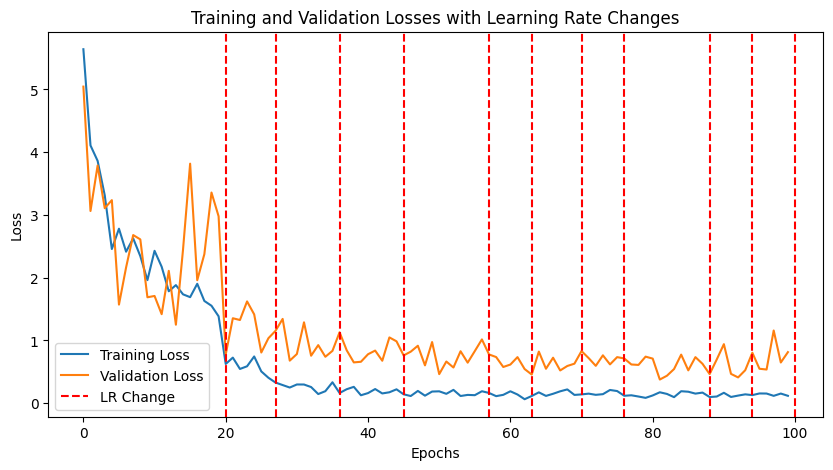

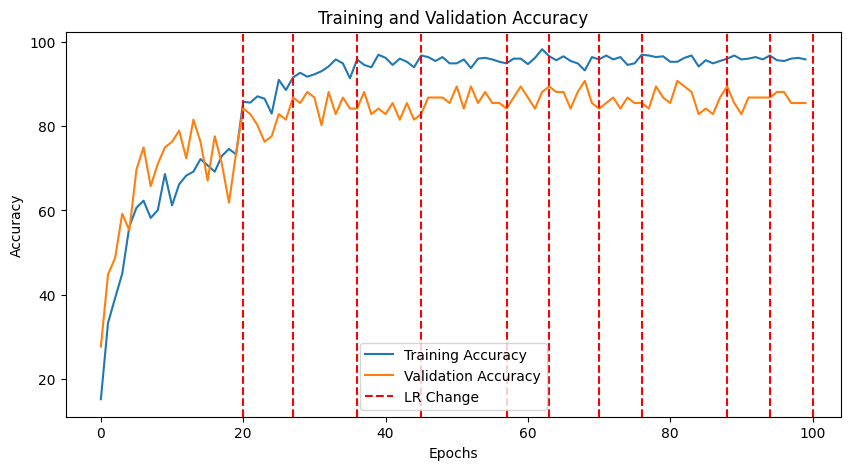

In [11]:
# Plot the training and validation losses with learning rate change points
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
for lr_epoch in lr_change_epochs:
    plt.axvline(x=lr_epoch, color='r', linestyle='--', label='LR Change' if lr_epoch == lr_change_epochs[0] else "")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses with Learning Rate Changes')
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
for lr_epoch in lr_change_epochs:
    plt.axvline(x=lr_epoch, color='r', linestyle='--', label='LR Change' if lr_epoch == lr_change_epochs[0] else "")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [12]:
# Testing loop
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
correct = 0
total = 0 
with torch.no_grad():
    for inputs, _, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {accuracy:.2f}%")


Test Loss: 1.1498, Test Accuracy: 84.42%


In [14]:
# Function to test an individual sample from the test split
def test_individual_test_sample(sample_idx):
    # Load a specific sample from the test dataset
    cube, _, label = test_dataset[sample_idx]
    
    # Move the sample to GPU if using CUDA
    cube = cube.to(device).unsqueeze(0)  # Add batch dimension
    label = label.to(device)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Disable gradient computation for inference
    with torch.no_grad():
        output = model(cube)
    
    # Apply softmax to get probabilities
    probabilities = torch.nn.functional.softmax(output, dim=1)
    
    # Get the predicted class
    predicted_class = torch.argmax(probabilities, dim=1)
    
    # Print the results
    print(f"Predicted class: {predicted_class.item()}, Probability: {probabilities[0][predicted_class.item()]:.4f}")
    print(f"True label: {label.item()}")

# Test an individual sample from the test split (e.g., sample index 0)

for i in range(800):
    test_individual_test_sample(i)
    print('\n')


Predicted class: 24, Probability: 0.4043
True label: 0


Predicted class: 0, Probability: 0.8282
True label: 0


Predicted class: 1, Probability: 1.0000
True label: 1


Predicted class: 1, Probability: 1.0000
True label: 1


Predicted class: 2, Probability: 1.0000
True label: 2


Predicted class: 2, Probability: 0.7839
True label: 2


Predicted class: 3, Probability: 1.0000
True label: 3


Predicted class: 3, Probability: 1.0000
True label: 3


Predicted class: 4, Probability: 1.0000
True label: 4


Predicted class: 4, Probability: 1.0000
True label: 4


Predicted class: 5, Probability: 1.0000
True label: 5


Predicted class: 1, Probability: 0.5026
True label: 5


Predicted class: 8, Probability: 0.7844
True label: 6


Predicted class: 6, Probability: 1.0000
True label: 6


Predicted class: 6, Probability: 1.0000
True label: 6


Predicted class: 7, Probability: 0.9908
True label: 7


Predicted class: 7, Probability: 1.0000
True label: 7


Predicted class: 8, Probability: 1.0000
True la

IndexError: list index out of range

In [ ]:
torch.save(model.state_dict(), 'resnet.pth')

In [ ]:
for name, param in model.named_parameters():
    print(name)

In [ ]:
models.